# Ex 13

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
folder = "media/casper/"

c = np.load(folder + 'calib.npy', allow_pickle=True).item()
c

{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]),
 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
        [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]),
 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
        [ 0.07619891,  0.99687725,  0.02072451],
        [-0.39852369,  0.01139647,  0.91708726]]),
 't': array([[-407.240143 ],
        [  -1.5053668],
        [  85.688652 ]])}

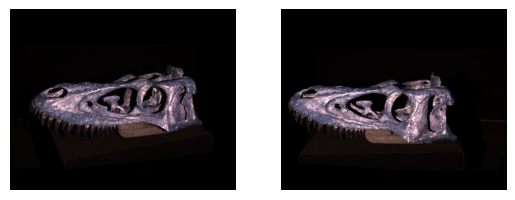

In [6]:
im0 = cv2.imread(folder+"sequence/frames0_0.png")
im1 = cv2.imread(folder+"sequence/frames1_0.png")

# Before rectification
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im0)
ax[0].axis('off')
ax[1].imshow(im1)
ax[1].axis('off')
plt.show()

In [7]:
im0 = cv2.imread(folder + "sequence/frames0_0.png")
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
                           c['d1'], size, c['R'], c['t'], flags=0)

R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)
